In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    classification_report,
    confusion_matrix)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        pass 

In [3]:
data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'
hermorrhage_png = glob.glob(os.path.join(data_dir, 'Kanama/PNG/*.png'))
ischemia_png = glob.glob(os.path.join(data_dir, 'İskemi/PNG/*.png'))
no_stroke_png = glob.glob(os.path.join(data_dir, 'İnme Yok/*.png'))

images = []
labels = []

for img_path in hermorrhage_png:
    images.append(img_path)
    labels.append(1)

for img_path in ischemia_png:
    images.append(img_path)
    labels.append(1)

for img_path in no_stroke_png:
    images.append(img_path)
    labels.append(0)

print(f"Count images: {len(images)}")
print(f"Count labels: {len(labels)}")

Count images: 6774
Count labels: 6774


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 1
EPOCHS = 100

In [5]:
data_df = pd.DataFrame({
    'filename': images,
    'class': labels
})

train_df, val_df = train_test_split(
    data_df,
    test_size=0.15,
    stratify=data_df['class'],
    random_state=42
)

In [6]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image

def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def create_dataset_train(df, batch_size):
    list_ds = tf.data.Dataset.from_tensor_slices((df['filename'].values, df['class'].values))
    ds = list_ds.map(lambda filename, label: (parse_image(filename), tf.cast(label, tf.float32)),
                     num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(ds, batch_size)
    return ds

def create_dataset_val_test(df, batch_size):
    list_ds = tf.data.Dataset.from_tensor_slices((df['filename'].values, df['class'].values))
    ds = list_ds.map(lambda filename, label: (parse_image(filename), tf.cast(label, tf.float32)),
                     num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [7]:
class_weights_calc = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights_calc))

In [8]:
train_ds = create_dataset_train(train_df, BATCH_SIZE)
val_ds = create_dataset_val_test(val_df, BATCH_SIZE)

In [9]:
base_model = EfficientNetV2B0(weights='imagenet',
                              include_top=False,
                              input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(name="gap"),
    layers.Dropout(0.3, name="head_dropout"),
    layers.Dense(128, activation='relu', name="dense_1"),
    layers.Dense(NUM_CLASSES, activation='sigmoid', name="output")
], name="StrokeClassifier_EfficientNetV2B0")

model.summary() # Giữ lại summary để xem cấu trúc

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "StrokeClassifier_EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gap (GlobalAveragePooling2D)         │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_dropout (Dropout)               │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,083,409 (23.21 MB)

 Trainable params: 6,022,801 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_lr=1e-7
)

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    min_delta=0.0001
)

callbacks_list = [lr_scheduler, early_stopper]

In [12]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks_list,
    class_weight=class_weight_dict
)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 171s 473ms/step - accuracy: 0.6830 - loss: 0.6941 - val_accuracy: 0.7365 - val_loss: 0.5824 - learning_rate: 1.0000e-05
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.7478 - loss: 0.5720 - val_accuracy: 0.7876 - val_loss: 0.5018 - learning_rate: 1.0000e-05
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.7984 - loss: 0.4809 - val_accuracy: 0.8486 - val_loss: 0.3940 - learning_rate: 1.0000e-05
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.8452 - loss: 0.3837 - val_accuracy: 0.8810 - val_loss: 0.3194 - learning_rate: 1.0000e-05
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.8855 - loss: 0.3102 - val_accuracy: 0.9066 - val_loss: 0.2656 - learning_rate: 1.0000e-05
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9118 - loss: 0.2598 - val_accuracy: 0.9194 - val_loss: 0.2246 - learning_rate: 1.0000e-05
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━

In [13]:
model_save_path = '/kaggle/working/efficientnetv2b0_stroke_classifier.keras'
model.save(model_save_path)

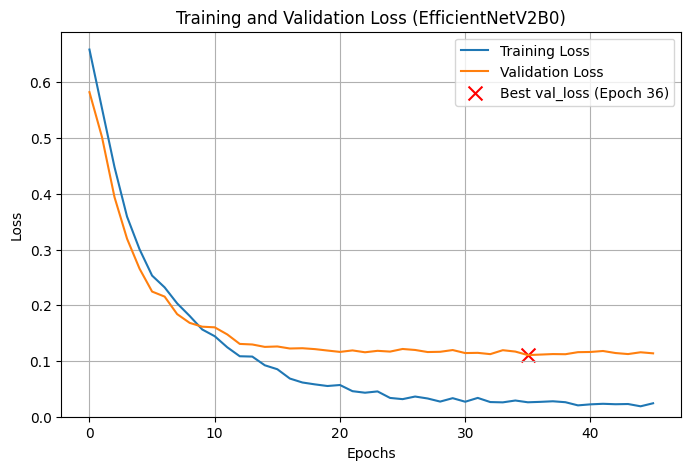

In [14]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
actual_epochs = len(loss)
epochs_range = range(actual_epochs)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
best_epoch_idx = np.argmin(val_loss)
plt.scatter(best_epoch_idx, val_loss[best_epoch_idx], s=100, c='red', marker='x', label=f'Best val_loss (Epoch {best_epoch_idx+1})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (EfficientNetV2B0)')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

In [15]:
val_ds_for_predict = create_dataset_val_test(val_df, BATCH_SIZE)
y_pred_proba_val = model.predict(val_ds_for_predict)
y_true_val = val_df['class'].values

if len(y_pred_proba_val) != len(y_true_val):
     y_true_val = y_true_val[:len(y_pred_proba_val)]

precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_proba_val)
f1_scores = np.array([
    2 * (p * r) / (p + r) if (p + r) > 0 else 0
    for p, r in zip(precision[:-1], recall[:-1])
])
valid_thresholds = thresholds[:len(f1_scores)]

chosen_threshold = 0.5 # Default threshold
best_f1_idx = -1
if len(f1_scores) > 0:
    best_f1_idx = np.argmax(f1_scores)
    best_threshold_f1 = valid_thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    best_precision_f1 = precision[best_f1_idx + 1]
    best_recall_f1 = recall[best_f1_idx + 1]

    target_recall = 0.88
    recall_indices = np.where(recall[:-1] >= target_recall)[0]
    if len(recall_indices) > 0:
        best_f1_for_recall_local_idx = np.argmax(f1_scores[recall_indices])
        best_threshold_recall_idx_global = recall_indices[best_f1_for_recall_local_idx]
        best_threshold_recall = valid_thresholds[best_threshold_recall_idx_global]
        best_precision_recall = precision[best_threshold_recall_idx_global + 1]
        actual_recall_recall = recall[best_threshold_recall_idx_global + 1]
        f1_recall = f1_scores[best_threshold_recall_idx_global]
        chosen_threshold = best_threshold_recall
    else:
        chosen_threshold = best_threshold_f1
else:
    chosen_threshold = 0.5

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step


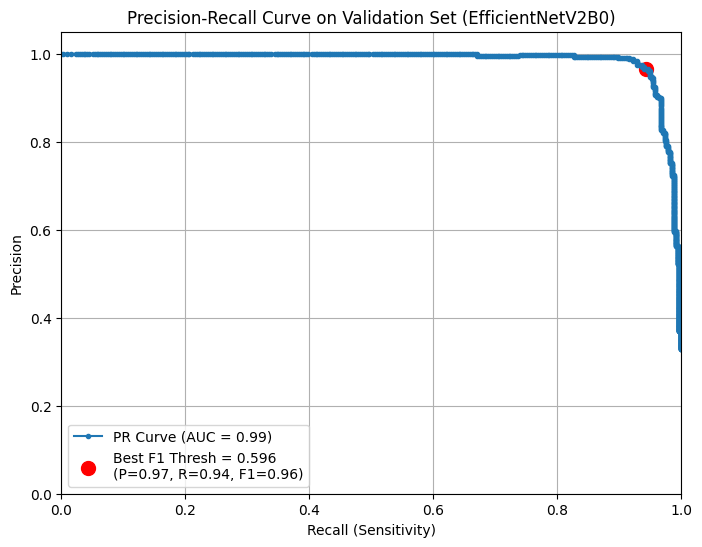

In [16]:
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {pr_auc:.2f})')
if best_f1_idx != -1 and (best_f1_idx + 1) < len(recall):
    plt.scatter(recall[best_f1_idx + 1], precision[best_f1_idx + 1], marker='o', s=100, color='red', label=f'Best F1 Thresh = {best_threshold_f1:.3f}\n(P={best_precision_f1:.2f}, R={best_recall_f1:.2f}, F1={best_f1:.2f})')
if 'best_threshold_recall_idx_global' in locals() and best_f1_idx != -1 and best_threshold_recall_idx_global != best_f1_idx:
     plt.scatter(actual_recall_recall, best_precision_recall, marker='x', color='green', s=100, label=f'Target R ({target_recall}) Thresh = {best_threshold_recall:.3f}\n(P={best_precision_recall:.2f}, R={actual_recall_recall:.2f}, F1={f1_recall:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Validation Set (EfficientNetV2B0)')
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.show()

               precision    recall  f1-score   support

No Stroke (0)       0.97      0.98      0.98       683
   Stroke (1)       0.97      0.94      0.95       334

     accuracy                           0.97      1017
    macro avg       0.97      0.96      0.97      1017
 weighted avg       0.97      0.97      0.97      1017



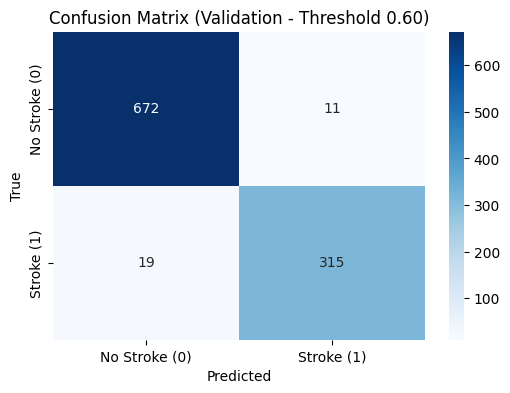

In [17]:
y_pred_val_adjusted = (y_pred_proba_val.flatten() > chosen_threshold).astype(int)
print(classification_report(y_true_val, y_pred_val_adjusted, target_names=['No Stroke (0)', 'Stroke (1)'], zero_division=0)) # Giữ lại report này

cm_val_adjusted = confusion_matrix(y_true_val, y_pred_val_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke (0)', 'Stroke (1)'],
            yticklabels=['No Stroke (0)', 'Stroke (1)'])
plt.title(f'Confusion Matrix (Validation - Threshold {chosen_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
test_data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum/PNG/'
cevaplar_path = os.path.join('/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum/ASAMA1_Cevaplar.txt')

png_files = glob.glob(os.path.join(test_data_dir, '*.png'))
labels_dict = {}
try:
    with open(cevaplar_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = [part.strip() for part in line.strip().split('\t')]
            if len(parts) == 2 and parts[0] and parts[1] and parts[1] in ['0', '1']:
                labels_dict[f"{parts[0]}.png"] = int(parts[1])
except FileNotFoundError:
    pass # Bỏ qua lỗi nếu không tìm thấy tệp
except Exception as e:
    pass # Bỏ qua các lỗi khác

test_images = []
test_labels = []
for png_file in png_files:
    filename = os.path.basename(png_file)
    if filename in labels_dict:
        test_images.append(png_file)
        test_labels.append(labels_dict[filename])

test_data = pd.DataFrame({
    'filename': test_images,
    'class': test_labels
})

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 886ms/step
               precision    recall  f1-score   support

No Stroke (0)     0.9630    1.0000    0.9811       130
   Stroke (1)     1.0000    0.9286    0.9630        70

     accuracy                         0.9750       200
    macro avg     0.9815    0.9643    0.9720       200
 weighted avg     0.9759    0.9750    0.9748       200



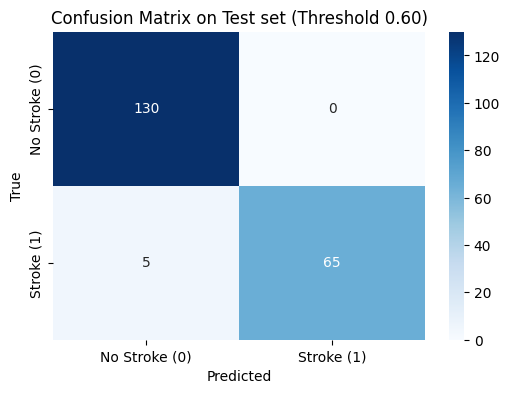

In [19]:
if not test_data.empty:
    test_ds = create_dataset_val_test(test_data, BATCH_SIZE)
    y_pred_proba_test = model.predict(test_ds)
    y_true_test = test_data['class'].values

    if len(y_pred_proba_test) != len(y_true_test):
         y_true_test = y_true_test[:len(y_pred_proba_test)]

    y_pred_test = (y_pred_proba_test.flatten() > chosen_threshold).astype(int)

    print(classification_report(y_true_test, y_pred_test, target_names=['No Stroke (0)', 'Stroke (1)'], digits = 4)) # Giữ lại report này

    cm_test = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke (0)', 'Stroke (1)'],
                yticklabels=['No Stroke (0)', 'Stroke (1)'])
    plt.title(f'Confusion Matrix on Test set (Threshold {chosen_threshold:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()